Importing libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

Grabbing same dataframe used for previous models and creating train/test sets

In [2]:
path = '/users/blaizelahman/Desktop/CFB Model/Original Data/Florida_State_model.csv'
modelFSU = pd.read_csv(path)

Before modeling, we're going to check the linearity of every single predictor

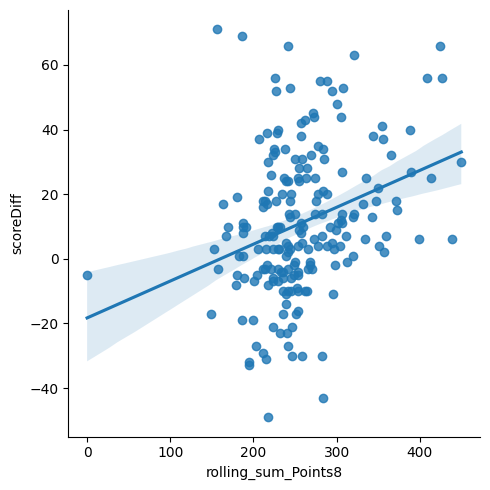

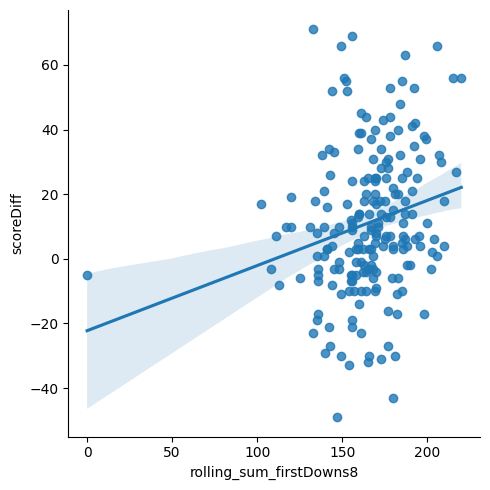

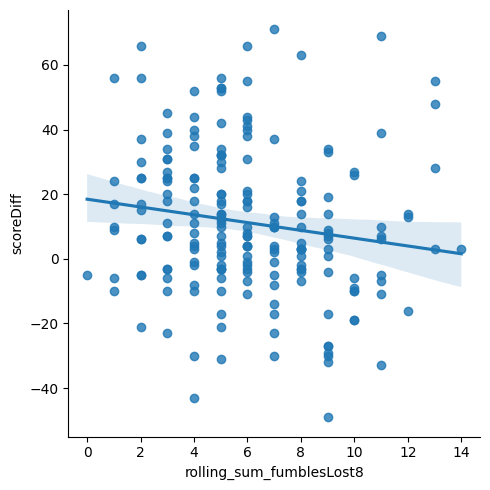

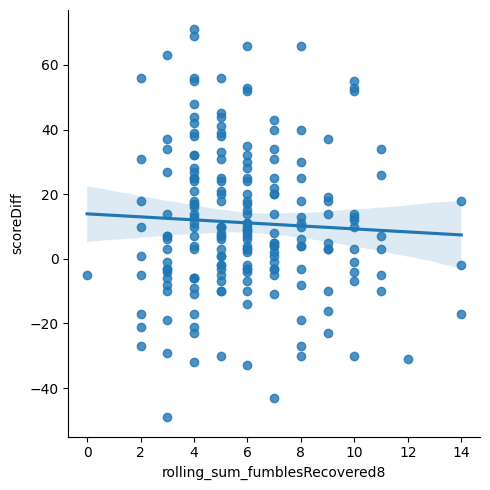

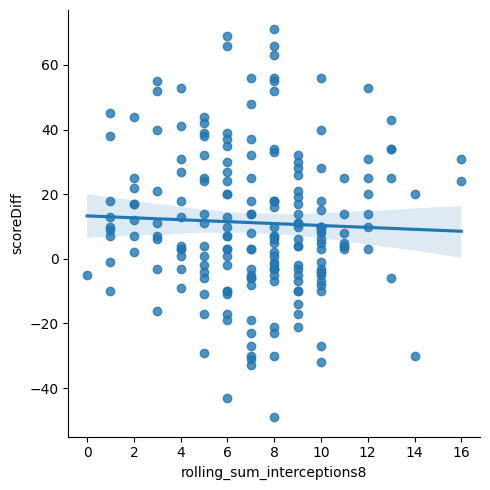

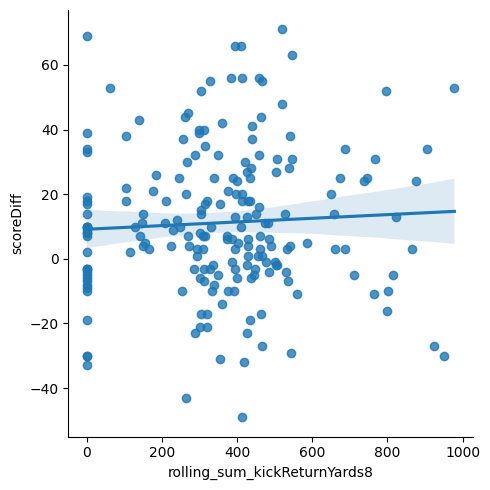

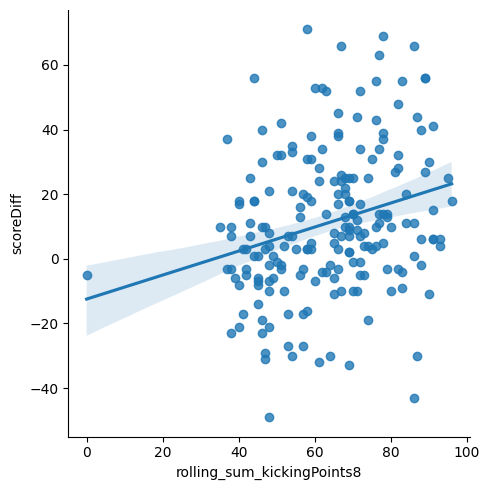

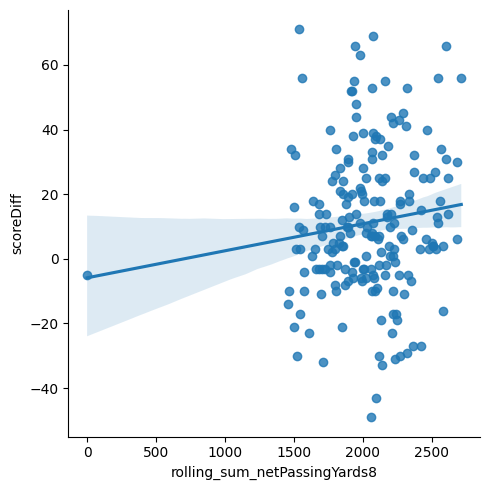

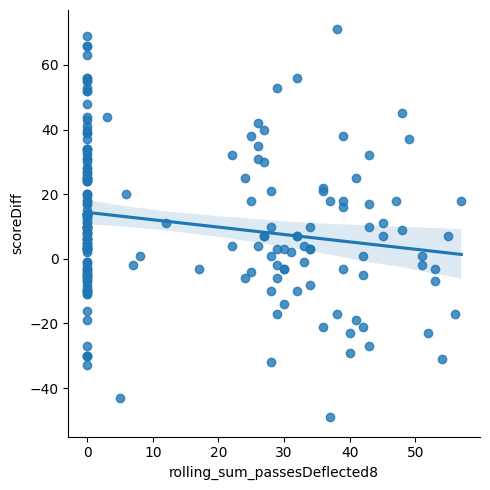

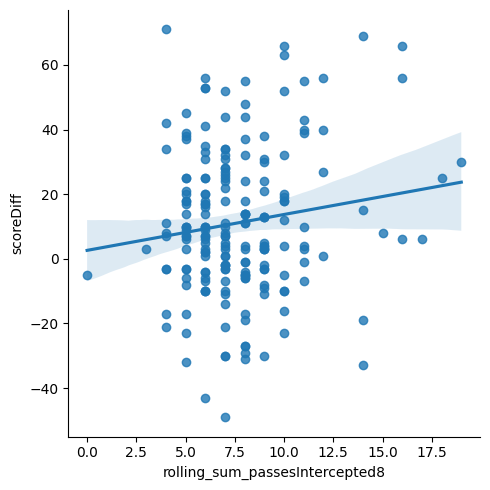

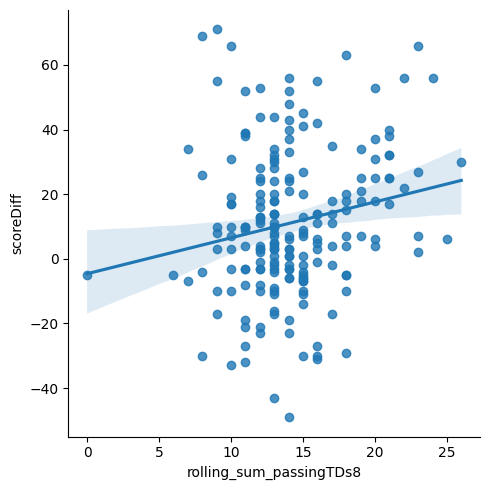

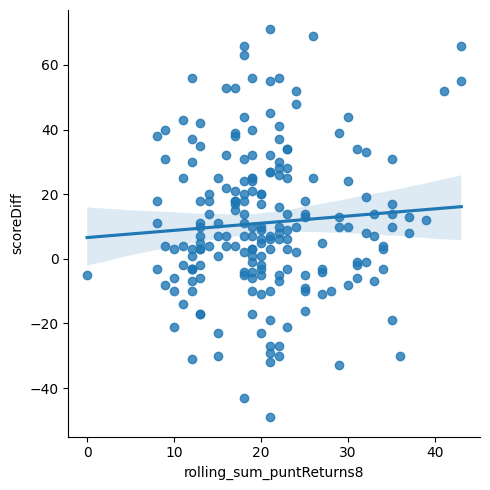

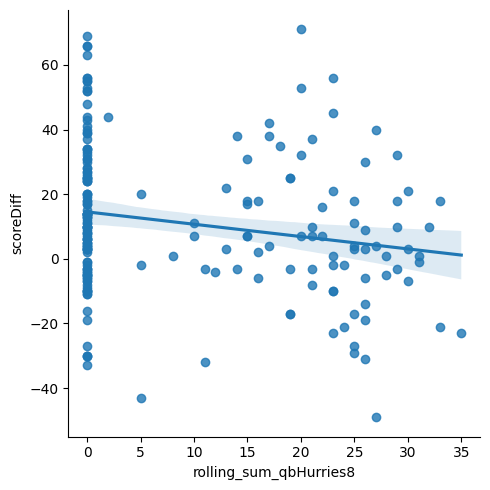

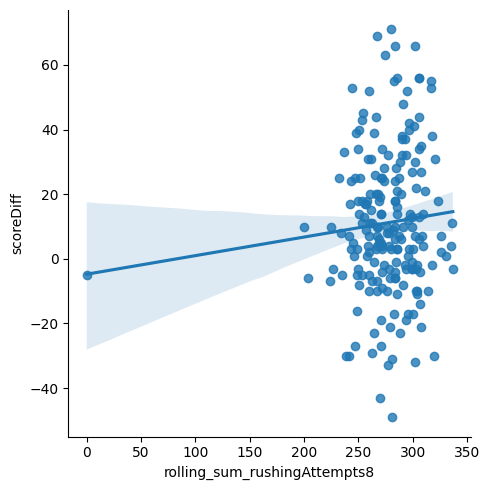

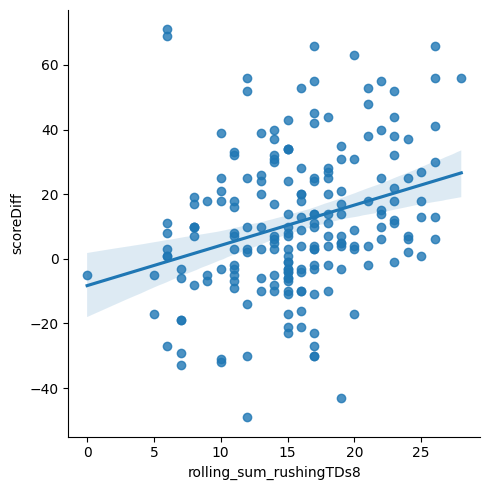

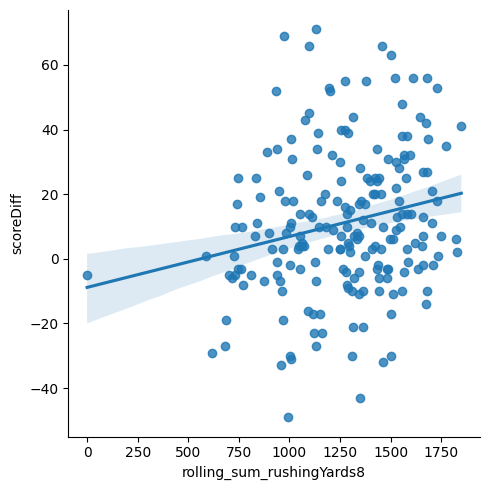

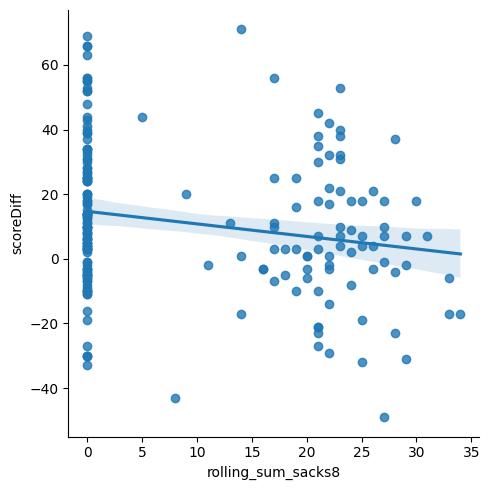

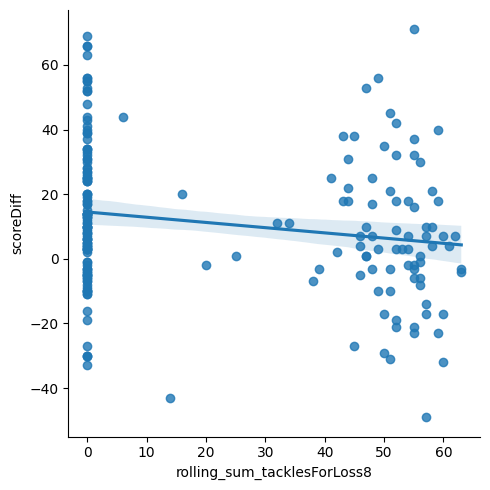

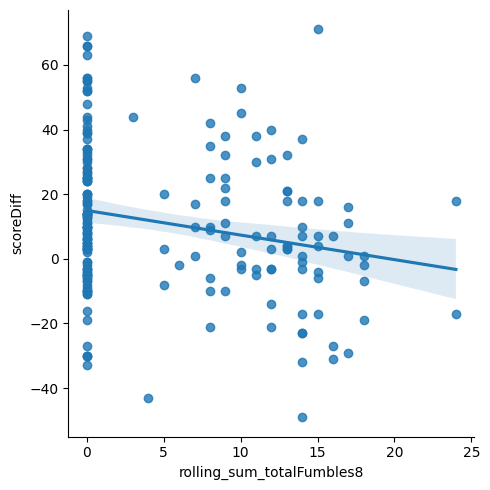

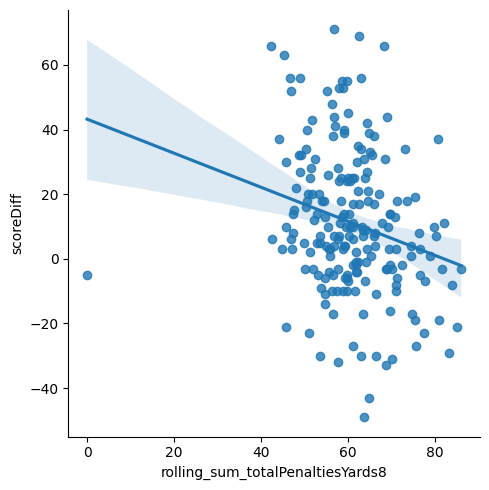

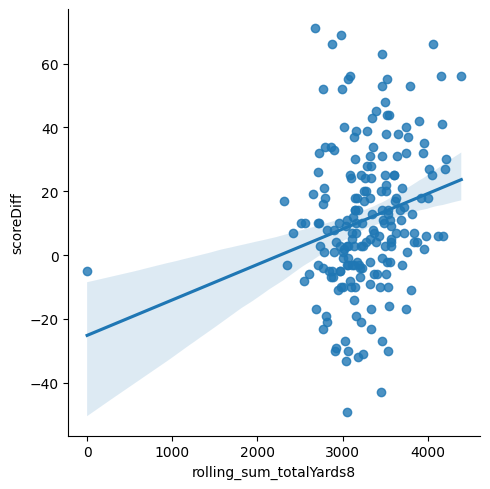

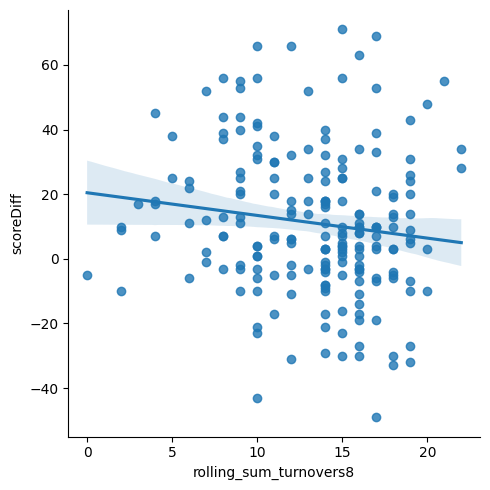

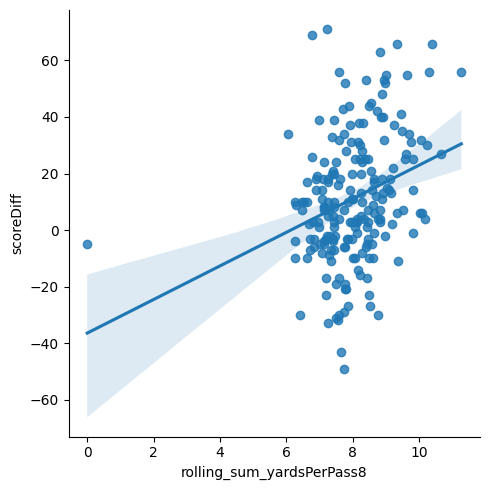

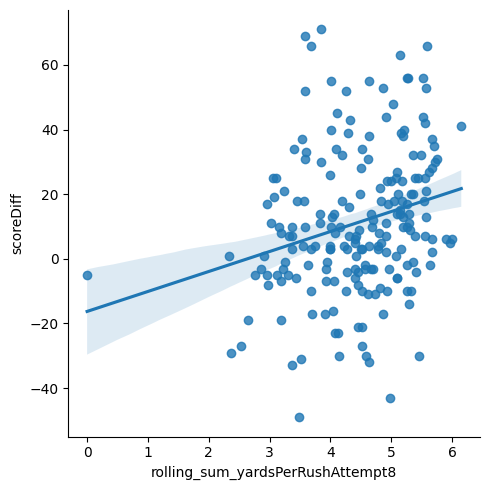

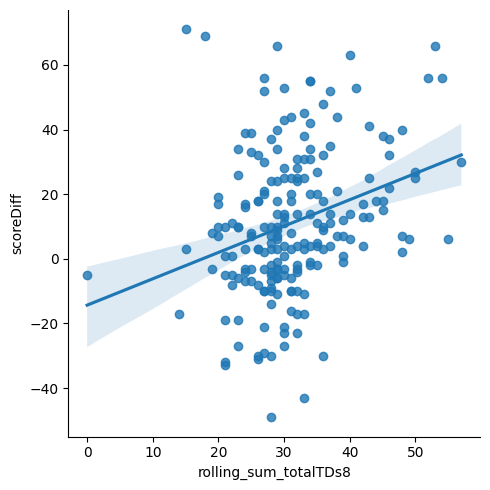

In [3]:
# only doing 8 so we don't have to check as many plots
rollingCols8 = [col for col in modelFSU.columns if col[-1] == '8']

for col in rollingCols8:
    sb.lmplot(x = col, y = 'scoreDiff', data = modelFSU)
    plt.show()


Need to do something about amount of 0's (missing data) in certain plots

From inspecting data, we can see that tacklesForLoss, sacks, tackles, passDeflected, defensiveTDs, qbHurries, and fumbles aren't counted until 2016, kick return stats until 2008, and penaltyYards until 2006. Will replace missing values with randomized values based on the linear relationship between the scoreDiff and those same stats

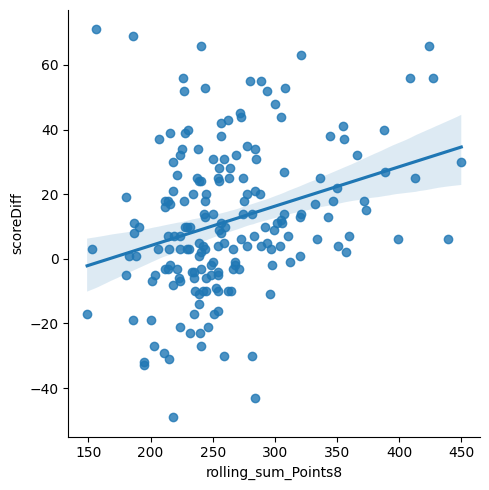

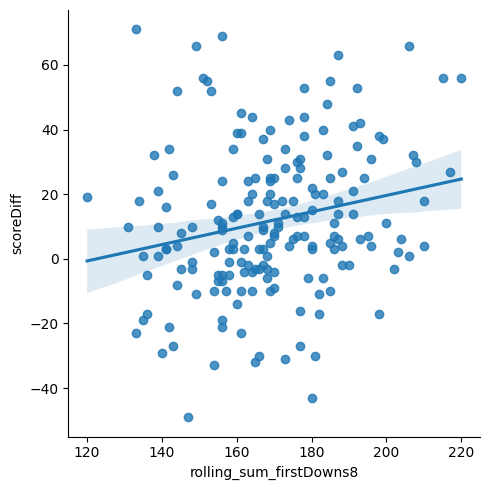

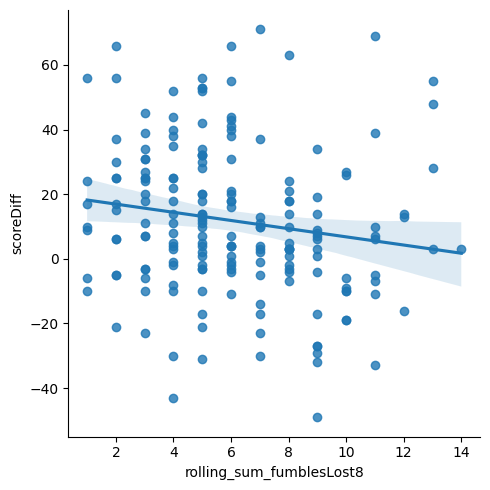

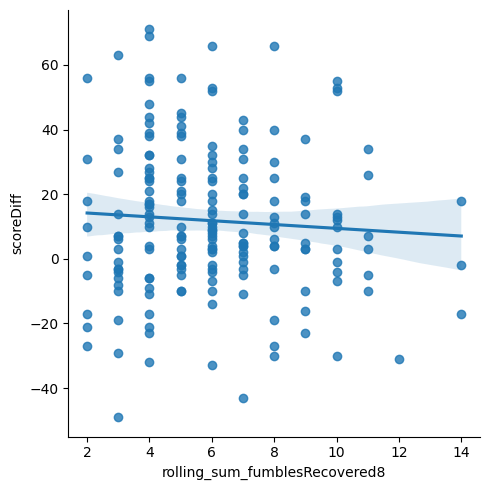

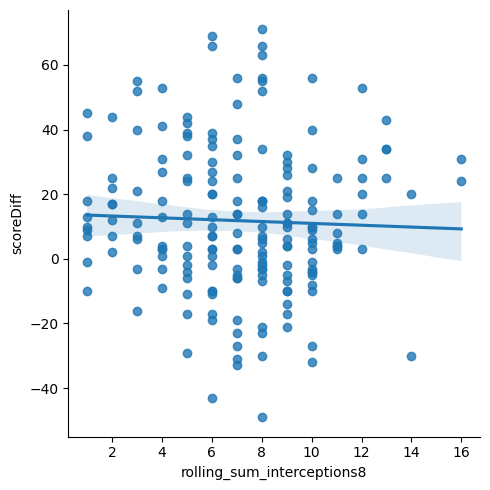

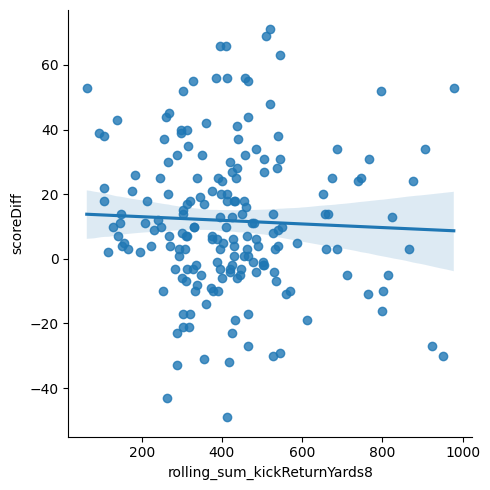

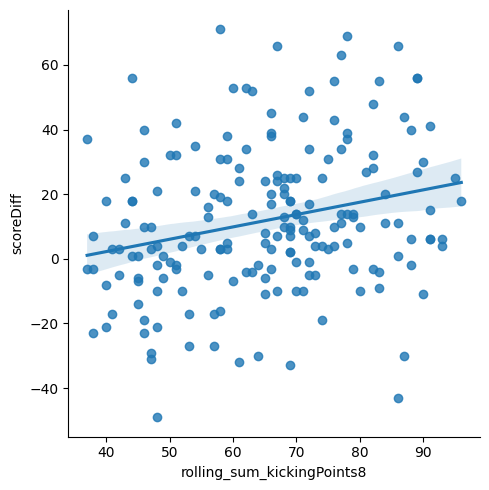

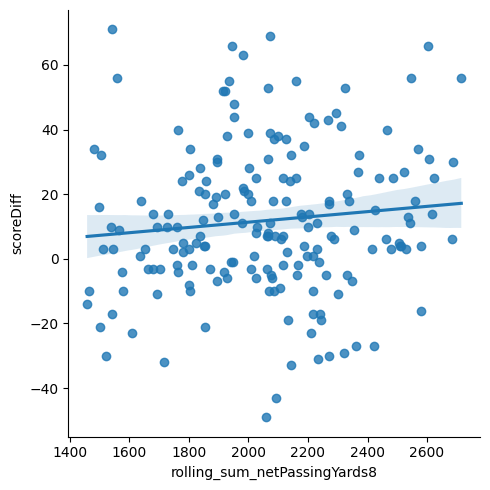

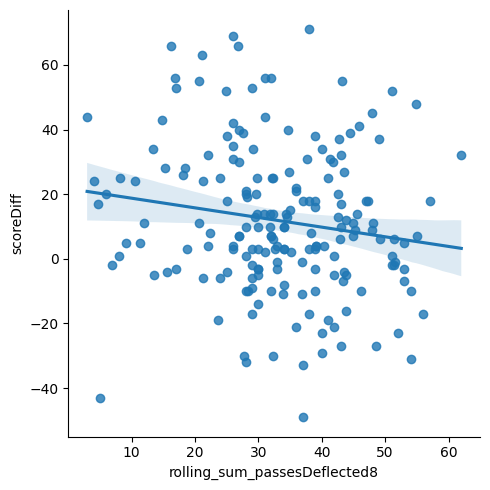

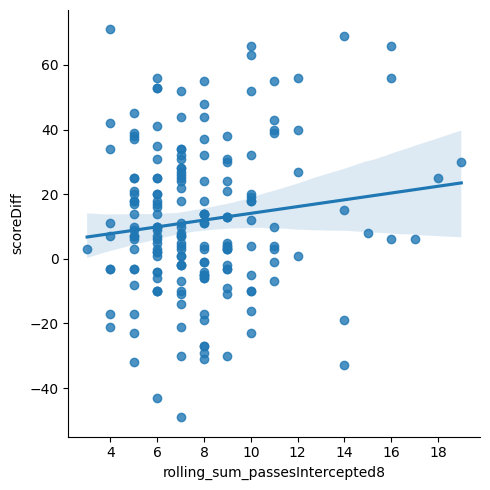

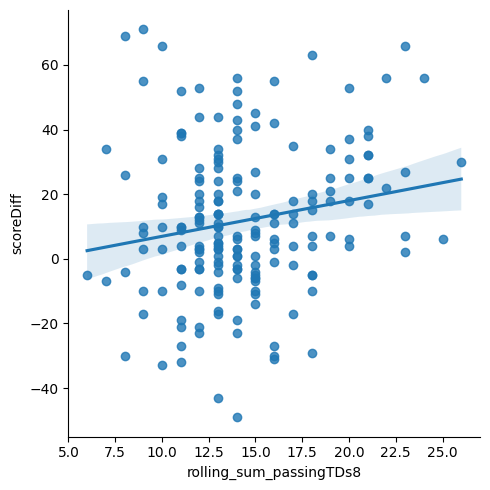

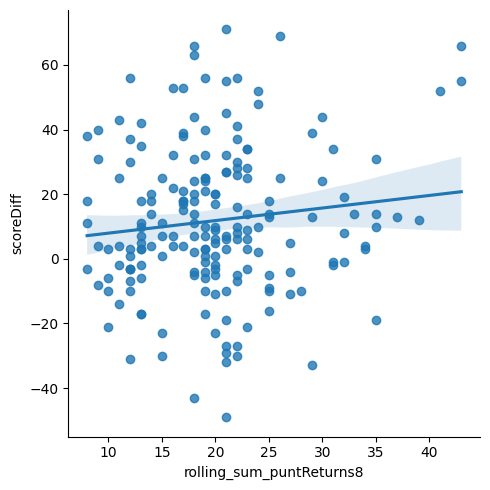

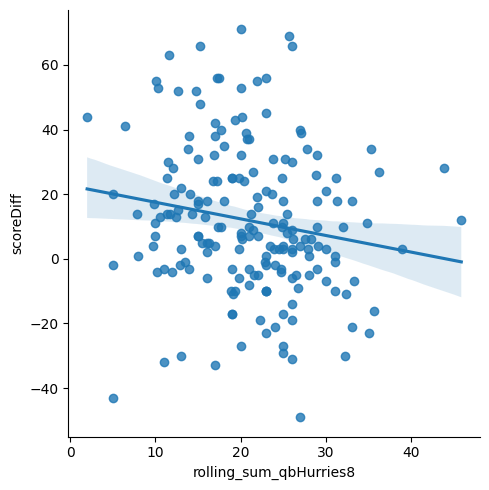

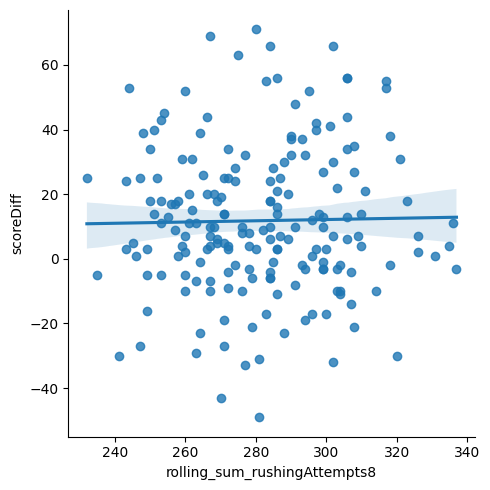

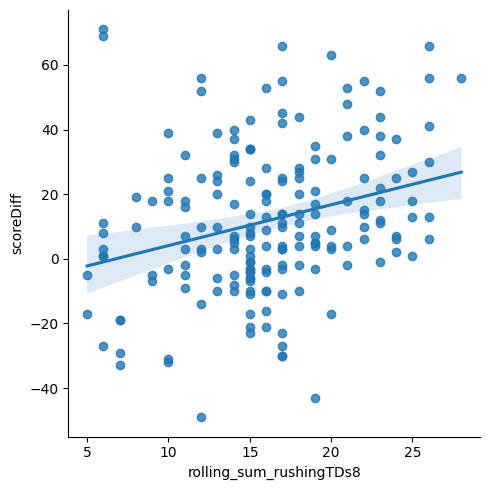

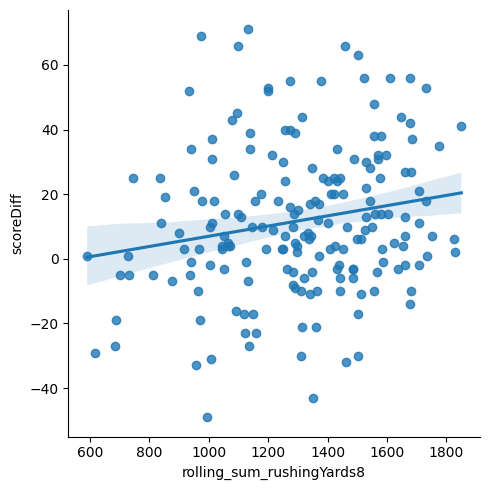

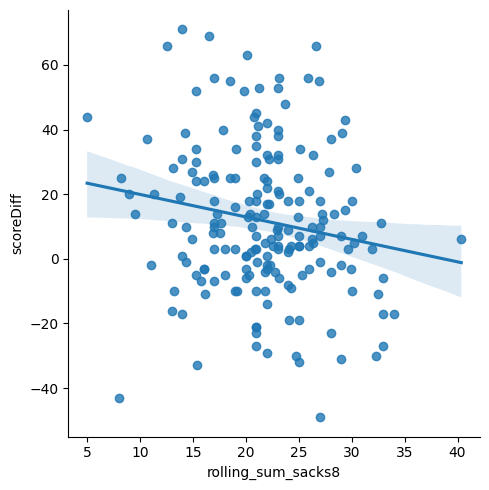

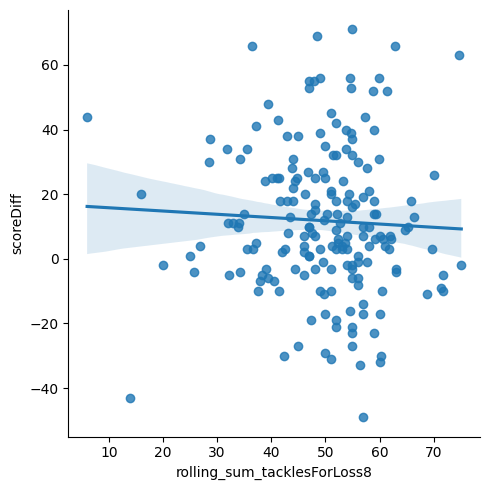

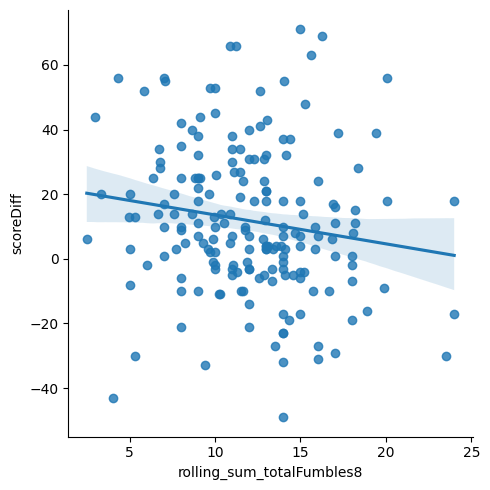

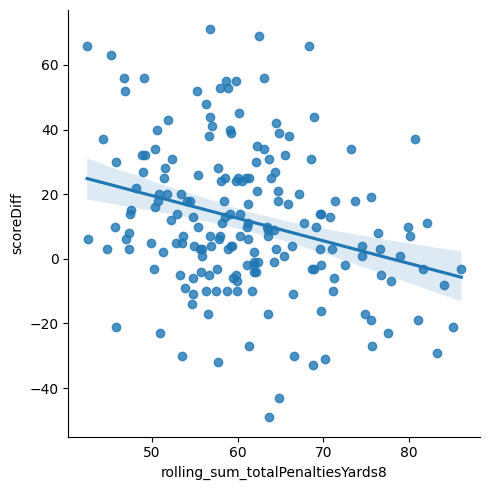

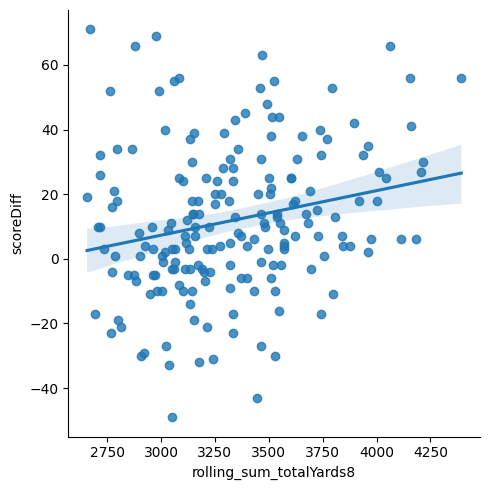

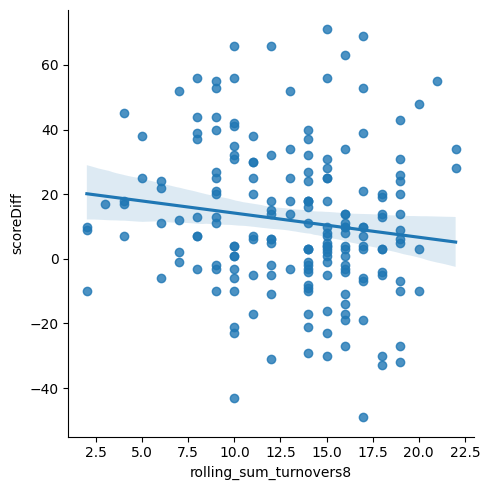

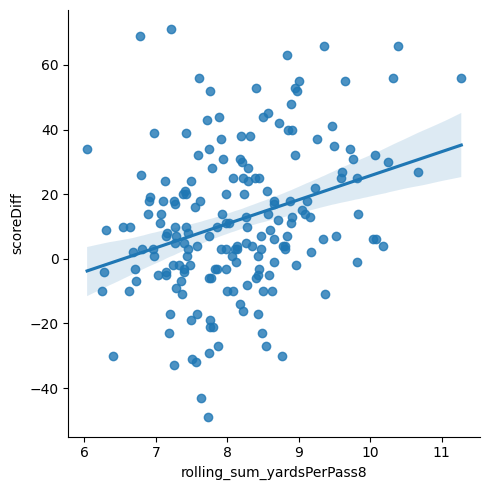

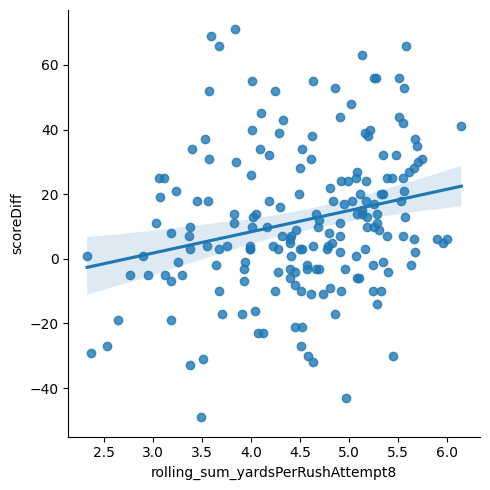

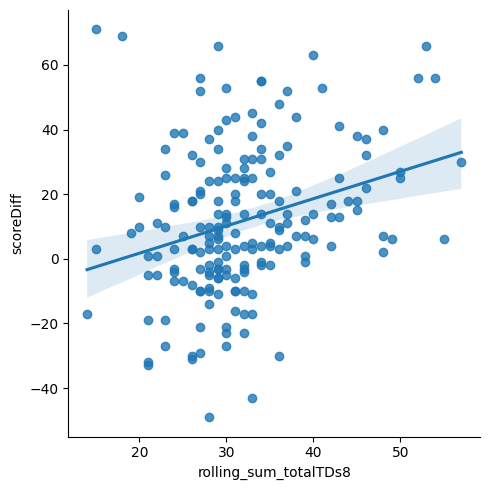

In [4]:
from sklearn.linear_model import LinearRegression

# throwing out first 20 rows due to missing rolling_sum data
modelFSU = modelFSU.drop(modelFSU.index[:20])
modelFSU = modelFSU.reset_index(drop = True)

# grabbing the columns that have missing data
rollingCols = [col for col in modelFSU.columns if 'rolling_sum' in col]
fixCols = [col for col in rollingCols if any(word in col for word in ['tackle', 'sacks', 'Deflected', 'defensive', 'qbHurries', 'fumbles', 'kickReturn', 'penalty', 'Fumble'])]

for col in fixCols:

        # replacing zeroes with null values
        modelFSU[col].replace(0, np.nan, inplace=True) 
        
        # creating a boolean series to show which indeces are non-nulls
        nonNulls = ~modelFSU[col].isnull()
    
        if nonNulls.any():

            # setting up X and y data for making a linear model based off the existing data
            X = modelFSU.loc[nonNulls, ['scoreDiff']].values.reshape(-1, 1)
            y = modelFSU.loc[nonNulls, col].values.reshape(-1, 1)
            
            # fit linear regression model on known data
            lr = LinearRegression()
            lr.fit(X, y)
            
            # grabbing rows where scoreDiff exists but the predictor is missing
            missingVals = modelFSU.loc[modelFSU[col].isnull(), ['scoreDiff']].values.reshape(-1, 1)
            
            if missingVals.shape[0] > 0:

                # predicting values for the missing rows based on scoreDiff
                preds = lr.predict(missingVals).flatten()
                
                # grabbing the standard deviation of the existing data
                std = modelFSU[col].std(skipna = True)
                
                # using the predicted values to generate a random distribution based off of the predictions
                # and spread of the existing data
                sampleVals = np.random.normal(loc = preds, scale = std, size = len(preds))
                
                # replacing the null values with generated sample values
                modelFSU.loc[modelFSU[col].isnull(), col] = sampleVals


# checking linearity again
for col in rollingCols8:
    sb.lmplot(x = col, y = 'scoreDiff', data = modelFSU)
    plt.show()

Adding and using train_test_split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = modelFSU[rollingCols]
y = modelFSU[['scoreDiff']]

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

Importing standard scaler

In [7]:
from sklearn.preprocessing import StandardScaler

Importing and setting up lasso regression

In [8]:
from sklearn.linear_model import Lasso

In [9]:
lasso = Lasso(alpha = 1)

In [10]:
# new pipeline with scaler and lasso
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', StandardScaler()),
    ('regressor', lasso)
])

Adding more information like coefficients and R2 score

In [11]:
from sklearn.metrics import r2_score

In [12]:
def fitPrint(pipe, xTrain, yTrain, xTest, yTest):

    # fittng the model and getting predictions
    pipe.fit(xTrain, yTrain)
    trainPreds = pipe.predict(xTrain)
    testPreds = pipe.predict(xTest)

    # getting features, their coefficients, and intercept
    coefs = pipe.named_steps['regressor'].coef_
    
    # creating a dataframe with features and their corresponding coefficients
    coefDF = pd.DataFrame({'Feature': rollingCols, 'Coefficient': coefs})

    # grabbing the features selected by lasso
    features = coefDF[coefDF['Coefficient'] != 0]

    print(features)
    
    print("Model intercept:", pipe.named_steps['regressor'].intercept_)

    # getting MAE from model
    print('Training error: ' + str(mean_absolute_error(yTrain, trainPreds)))
    print('Test error: ' + str(mean_absolute_error(yTest, testPreds)))

    # using cross-validation to get average MAE
    cvScore = cross_val_score(pipe, xTrain, yTrain, cv = 5, scoring = 'neg_mean_absolute_error')
    print('Mean MAE from cross-validation:', -cvScore.mean())

    # getting R2 scores from model
    print('Training R2 score: ' + str(r2_score(yTrain, trainPreds)))
    print('Test R2 score: ' + str(r2_score(yTest, testPreds)))


In [13]:
fitPrint(pipe, xTrain, yTrain, xTest, yTest)

                                  Feature  Coefficient
8           rolling_sum_passesDeflected20    -0.364992
16                    rolling_sum_sacks20     1.582633
19      rolling_sum_totalPenaltiesYards20    -0.359520
22             rolling_sum_yardsPerPass20     0.271767
33           rolling_sum_passesDeflected8    -0.466098
35                rolling_sum_passingTDs8     1.470148
41                     rolling_sum_sacks8    -0.010997
44       rolling_sum_totalPenaltiesYards8    -1.129369
46                 rolling_sum_turnovers8    -0.268062
48       rolling_sum_yardsPerRushAttempt8     0.627312
49                  rolling_sum_totalTDs8     1.969362
52          rolling_sum_fumblesLost20_opp     0.531377
53     rolling_sum_fumblesRecovered20_opp     0.786541
55      rolling_sum_kickReturnYards20_opp     1.563978
58      rolling_sum_passesDeflected20_opp    -2.358743
64           rolling_sum_rushingTDs20_opp    -0.567928
66                rolling_sum_sacks20_opp    -1.043330
67       r

Some improvement with adding standard scaler and using lasso regression

Determining best alpha level for model using GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV

Setting up parameter grid

In [15]:
paramGrid = {
    'regressor__alpha': np.logspace(-4, 4, 50)
}

Remaking pipeline

In [16]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', StandardScaler()),
    ('regressor', Lasso())
])

Setting up and fitting grid search

In [17]:
gridSearch = GridSearchCV(pipe, paramGrid, cv = 5, scoring = 'neg_mean_absolute_error')

In [18]:
# ignoring the warnings that appear when running
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

gridSearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('scaler', StandardScaler()),
                                       ('regressor', Lasso())]),
             param_grid={'regressor__alpha': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.2919...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])},
             scoring='neg_mean_absolute_error')

In [19]:
-gridSearch.best_score_

13.43451738961673

In [20]:
gridSearch.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('regressor', Lasso(alpha=1.7575106248547894))])

Now we know best alpha

Now that the model is fairly robust, we'll look at its average error across all teams and see how it does

Making a function to predict missing data

In [21]:
def predictMissing(modelTeam):

    # picking out the columns with missing data
    rollingCols = [col for col in modelTeam.columns if 'rolling_sum' in col]
    fixCols = [col for col in rollingCols if any(word in col for word in ['tackle', 'sacks', 'Deflected', 'defensive', 'qbHurries', 'fumbles', 'kickReturn', 'penalty', 'Fumble'])]

    for col in fixCols:

        # replacing zeroes with null values 
        modelTeam[col].replace(0, np.nan, inplace=True) 
        
        # creating a boolean series to show which indeces are non-nulls
        nonNulls = ~modelTeam[col].isnull()
    
        if nonNulls.any():

            # setting up X and y data for making a linear model based off the existing data
            X = modelTeam.loc[nonNulls, ['scoreDiff']].values.reshape(-1, 1)
            y = modelTeam.loc[nonNulls, col].values.reshape(-1, 1)
            
            # fit linear regression model on known data
            lr = LinearRegression()
            lr.fit(X, y)
            
            # grabbing rows where scoreDiff exists but the predictor is missing
            missingVals = modelTeam.loc[modelTeam[col].isnull(), ['scoreDiff']].values.reshape(-1, 1)
            
            if missingVals.shape[0] > 0:

                 # predicting values for the missing rows based on scoreDiff
                preds = lr.predict(missingVals).flatten()
                
                # grabbing the standard deviation of the existing data
                std = modelTeam[col].std(skipna = True)
                
                # using the predicted values to generate a random distribution based off of the predictions
                # and spread of the existing data
                sampleVals = np.random.normal(loc = preds, scale = std, size = len(preds))
                
                # replacing the null values with generated sample values
                modelTeam.loc[modelTeam[col].isnull(), col] = sampleVals



Making function for the creation of train/test sets

In [22]:
def buildModel(modelTeam):

    # throwing out first 20 rows due to missing rolling_sum data
    modelTeam = modelTeam.drop(modelTeam.index[:20])
    modelTeam = modelTeam.reset_index(drop = True)

    # calling function to predict the missing values
    predictMissing(modelTeam)

    # setting up training and test sets
    X = modelTeam[rollingCols]
    y = modelTeam[['scoreDiff']]

    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

    # setting up pipeline
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
        ('scaler', StandardScaler()),
        ('regressor', Lasso())
    ])

    # setting up and performing grid search to find best alpha level
    paramGrid = {
        'regressor__alpha': np.logspace(-4, 4, 50)
    }

    gridSearch = GridSearchCV(pipe, paramGrid, cv = 5, scoring = 'neg_mean_absolute_error')

    gridSearch.fit(X, y)

    bestAlpha = gridSearch.best_params_['regressor__alpha']

    # setting up new pipeline with the ideal alpha level now
    betterPipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
        ('scaler', StandardScaler()),
        ('regressor', Lasso(alpha = bestAlpha))
    ])

    betterPipe.fit(X, y)

    testPreds = betterPipe.predict(xTest)

    # grabbing mean MAE
    cvScore = cross_val_score(betterPipe, xTrain, yTrain, cv = 5, scoring = 'neg_mean_absolute_error')

    # grabbing r2 score
    r2 = r2_score(yTest, testPreds)

    modelScores = [-cvScore.mean(), r2]

    return modelScores


Using glob to go through all the saved team dataframes and build models with them

In [23]:
import glob
import os

In [24]:
# grabbing all csv files in the CFB Model folder with the term 'model' in them
directory = '/Users/blaizelahman/Desktop/CFB Model/Original Data'
pattern = os.path.join(directory, '*model*.csv')

teamFiles = glob.glob(pattern)

# dictionary to hold each team and their model's score
modelScores = {}

for file in teamFiles:

    teamDF = pd.read_csv(file)

    # only looking at teams with at least 4 seasons worth of data
    if teamDF.shape[0] >= 56:

        scores = buildModel(teamDF)

        teamName = teamDF['School'][0]

        modelScores[teamName] = scores

        print(f'{teamName}: {scores}')    
        

Boston College: [12.941898610701724, 0.6961472805246347]
Rutgers: [14.661161546785575, 0.5506064050581225]
Auburn: [13.70083486080548, 0.6893495310909523]
North Texas: [12.703375469375278, 0.7684973644969572]
Nebraska: [12.97392332919361, 0.5472639167968352]
Oklahoma State: [13.708064815655282, 0.48739642861684873]
Arizona State: [10.971907956519578, 0.7042830612083774]
Eastern Michigan: [12.63643851604662, 0.4890930778922137]
Louisiana: [13.356280134593419, 0.6441245859018685]
Colorado State: [12.904332912348718, 0.4257708061523011]
Idaho: [11.794843874722307, 0.41424272859937006]
Illinois: [12.51629816473062, 0.5765239284760955]
Air Force: [11.808625890662316, 0.4840886160451756]
Kent State: [13.497749131249781, 0.5586388957373498]
Louisiana Monroe: [12.975688901767862, 0.5202259525106667]
Iowa: [11.763078963259343, 0.2642737205205449]
Akron: [10.352643974234429, 0.470152916775476]
Ohio: [12.383789104974982, 0.30107666158798285]
Georgia: [11.319313156095815, 0.6940639645574349]
South

Grabbing average model error and R2 score across all models

In [25]:
maeScores = [value[0] for value in modelScores.values()]
r2Scores = [value[1] for value in modelScores.values()]
print(f'Mean MAE: {np.mean(maeScores)} \nMean R2 Score: {np.mean(r2Scores)}')

Mean MAE: 12.976136159359866 
Mean R2 Score: 0.5239823586155375


Now that we have a relatively solid model, we will augment our team dataframes with more advanced stats beyond just the box score and see how that improves it